# Deep Learning for Human Activity Recognition

### Aim:
    This project aims to develop a Convolution Network to perform activtiy recognintion of physical activities using on-body Inertial Measurement Sensors.
    
    Tensorflow and Keras APIs were used for the development of a 1D Sequential CNN of 7 Layers.
    
    An old version of the Actitracker dataset from the  Wireless Sensor Data Mining (WISDM) lab at Fordham University, NY, USA was used to train and test the network. The dataset can be downloaded from: https://github.com/bharatm11/1D_CNN_Human_activity_recognition
    
    The activity states provided in the dataset are jogging, walking, ascending stairs, descending stairs, sitting and standing. The data was collected from 36 users using a smartphone in their pocket with the 20Hz sampling rate (20 values per second).
     

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Conv1D, MaxPooling1D,GlobalAveragePooling1D,GlobalAvgPool1D, Reshape, Activation
from keras import optimizers
import keras
from keras.utils import np_utils
#%matplotlib inline
plt.style.use('ggplot')
from keras.optimizers import SGD


/home/bharat/miniconda3/envs/CMSC422/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
Using TensorFlow backend.


### Pipeline

The training process starts by reading the data and normalizing it. This normalized data is then segmented into time slices of window size 80 which translates to 4 seconds long chunks of data. These chunks are then randomly split into training and test sets. For the results shown in this report, 70% data as taken into the test set and the remaining was used in the test set for validation of the training algorithm. This training data was fed to a 1D CNN network which is described below.




In [2]:
'''***********************'''
#DEFINE NETWORK PARAMETERS
trainSplitRatio = 0.7 # split ratio for test and validation
window_size = 80 #Length of time slice. Actitrac was recorded at 20Hz
numFilters1 = 100 # number of filters in first Conv1D layer
kernalSize = 10 # kernal size of the Conv2D layer
batchSize = 10
numNueronsFCL2 = 160 # number of filters in fully connected output layer 
dropout = 0.5 #dropout rate. % of neurons converted to 0 weight before softmax
epochs = 50
'''***********************'''

'***********************'

In [3]:
#DEFINE HELPER FUNCTIONS
def read_data(file_path):
    print("reading data")
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    print("finished reading data")
    return data

def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

def plot_activity(activity,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.pause(0.5)
    plt.show(block=False)
    fig.savefig(activity +'.png')

def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)

def segment_signal(data,window_size):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data["timestamp"], window_size):
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if(len(dataset["timestamp"][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["activity"][start:end])[0][0])
    return segments, labels
#READ AND NORMALIZE DATA
dataset = read_data('actitracker_raw.txt')
dataset.dropna(axis=0, how='any', inplace= True)
print("normalizing x")
dataset['x-axis'] = feature_normalize(dataset['x-axis'])
print("normalizing y")
dataset['y-axis'] = feature_normalize(dataset['y-axis'])
print("normalizing z")
dataset['z-axis'] = feature_normalize(dataset['z-axis'])

reading data
finished reading data
normalizing x
normalizing y
normalizing z


### This section plots one window size long plots for each class of the normalized data

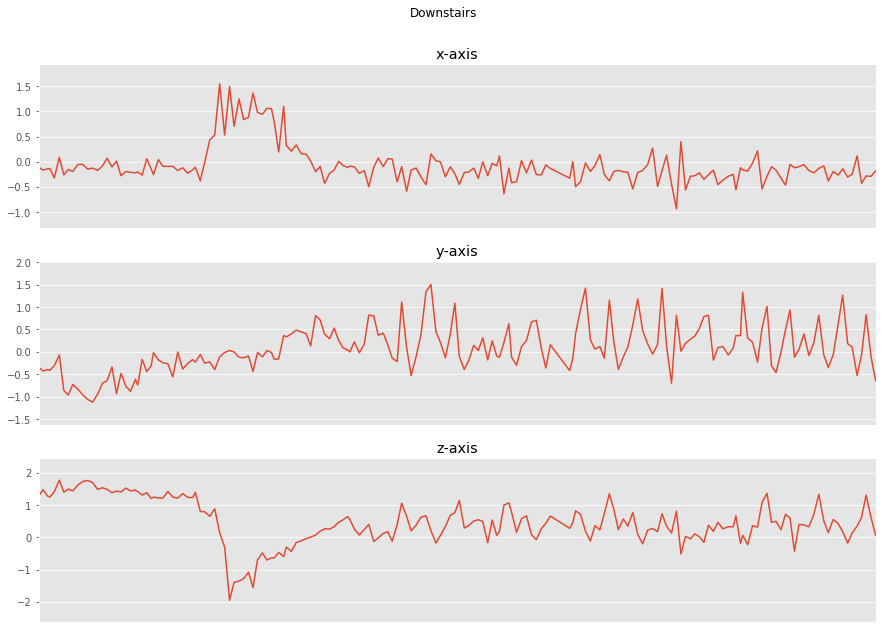

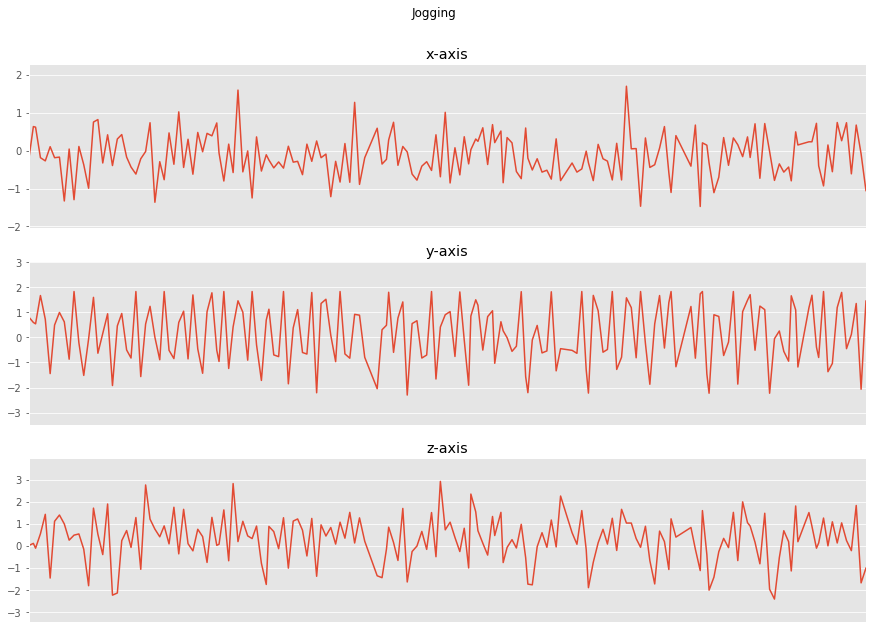

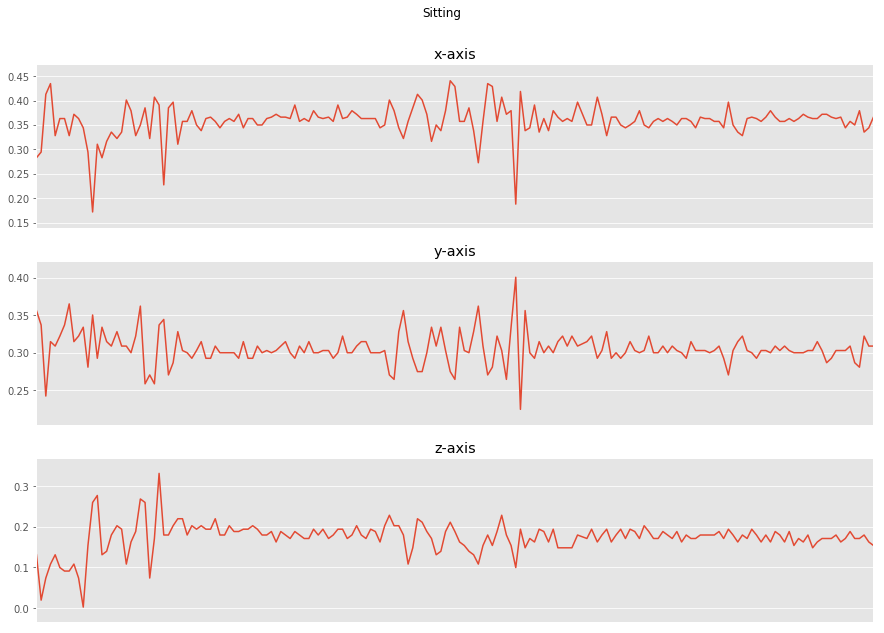

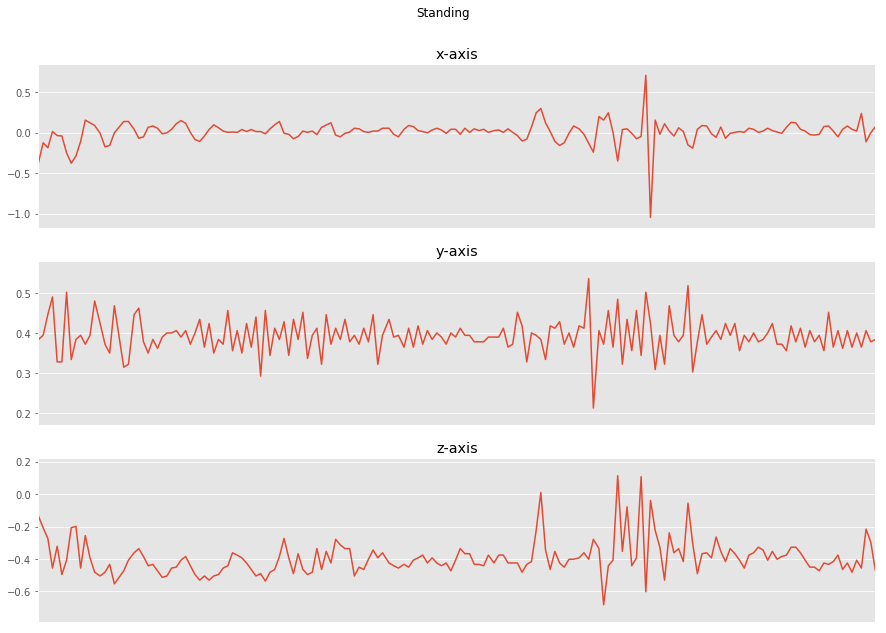

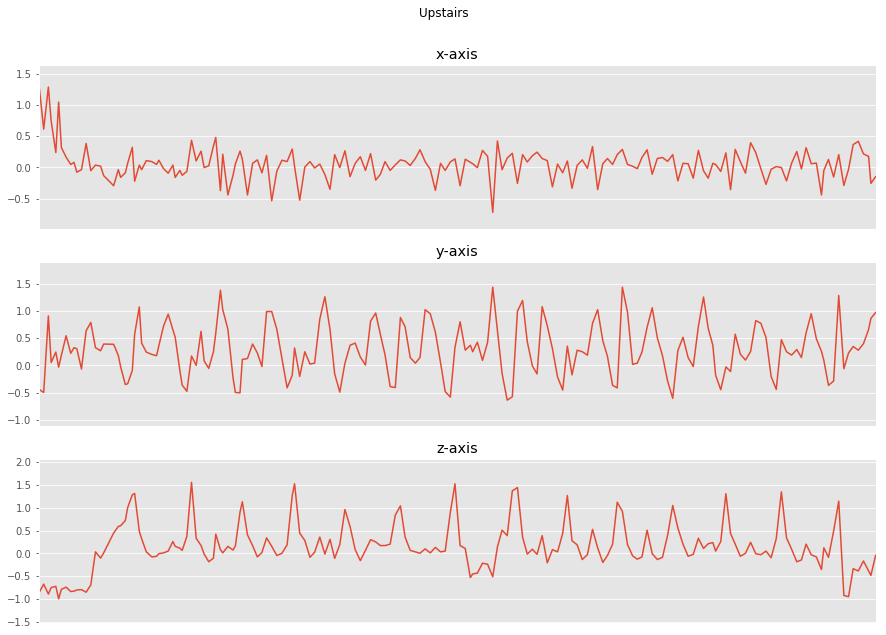

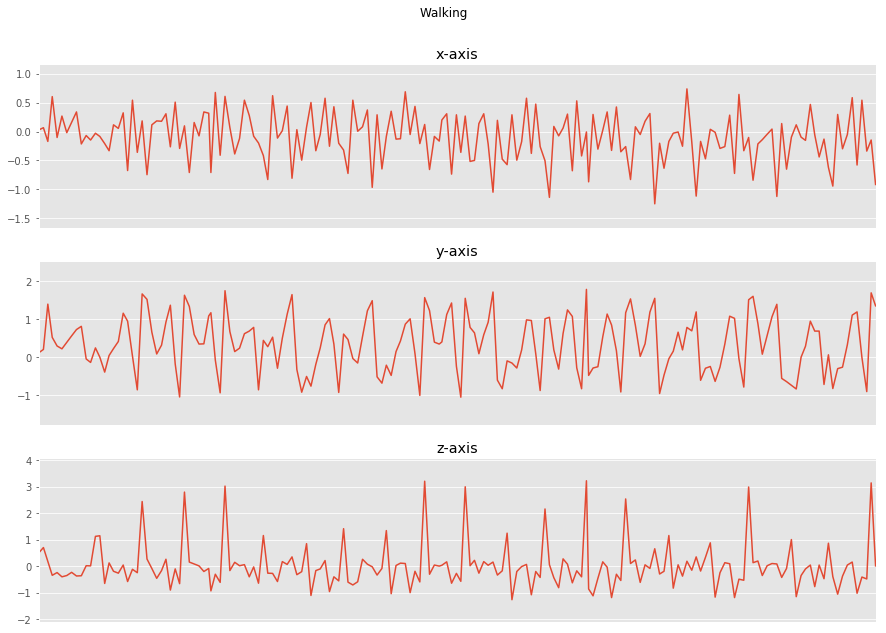

In [4]:
#PLOT WINDOW FOR EACH LABEL
for activity in np.unique(dataset["activity"]):
    subset = dataset[dataset["activity"] == activity][:180]
    plot_activity(activity,subset)


In [5]:
#SEGMENT DATA, LABELS INTO WINDOW_SIZE
print("segmenting data into windows")
segments, labels = segment_signal(dataset,window_size)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments), 1,window_size, 3)
print("segmented data in windows")
#SPLIT DATA INTO TEST AND TRAINING SETS
print("Splitting data into test and training sets")
train_test_split = np.random.rand(len(reshaped_segments)) < trainSplitRatio
train_x = reshaped_segments[train_test_split]
train_y = labels[train_test_split]
test_x = reshaped_segments[~train_test_split]
test_y = labels[~train_test_split]
print("Ready for training")

segmenting data into windows


/home/bharat/miniconda3/envs/CMSC422/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


segmented data in windows
Splitting data into test and training sets
Ready for training


In [6]:
#EXTRACT DATASET PARAMETERS
numOfRows = segments.shape[1]
print(numOfRows)
numOfColumns = segments.shape[2]
print(numOfColumns)
print(train_x.shape[2])
print(train_y.shape[1])
num_classes = labels.shape[1]
num_data_parameters = train_x.shape[3]
input_shape = window_size*num_data_parameters

80
3
80
6


### CNN Network

A 1D CNN network was used considering the dimensions of the data. Each row of the data consists of the x,y,z accelerations from the accelerometer and the height of the layer determines the number of instances of data equalling the window size which is 80 in our case. Only the size of the input and output layers needs to be specified explicitly. The netork estimates the size of the hidden layers on it's own.

The network used here is of sequential type which means that it's basically a stack of layers. These layers include:
* Input layer
* First 1D CNN Layer
* A max pooling layer
* Second 1D CNN Layer 
* An average pooling layer
* A dropout layer
* A fully connected Softmax Activated layer

**Input Layer:** The input data consists of 80 time slices long instances of 3-axis accelerometer. Hence, the size of the input layer needs to be reshaped to 80x3. The data passes through the input layer as a vector of length 240. The output for this layer is 80x3.

**First 1D CNN Layer:** This defines a filter of kernel size 10. 100 such filters are defined in this layer to enable it to learn 100 different features. **Input Layer:** The input data consists of 80 time slices long instances of 3-axis accelerometer. Hence, the size of the input layer needs to be reshaped to 80x3. The data passes through the input layer as a vector of length 240. The output for this layer is a 71x100 matrix of neurons where the weights of each filter are defined column-wise.

**A max pooling layer:** This is used to reduce the complexity of the output and to prevent overfitting of the data. Using a pooling layer size of 3 reduces the size of the output matrix to 1/3rd of the input matrix.

**Second 1D CNN Layer:** This layer enables the network to pick up higher level features which were missed in the First CNN layer. The output of this layer is a 14x160 matrix.

**Average pooling layer:** This averages the value of two weights in the network thereby further reducing overfitting. The output is 1x160 matrix of neurons.

**Dropout layer:** This randomly assignms a weight of 0 to the neurons in the network. A value of 0.5 indicates that 50% of the neurons turn 0.

**Fully connected Softmax Activated layer:** This reduces the output to the desired height of 6 which indicates the number of activity classes in the data. Softmax forces all six outputs of the neural network to sum up to one.

In [7]:
#DEFINE CNN MODEL
# 1D CNN neural network

model_m = Sequential()
model_m.add(Reshape((window_size, num_data_parameters), input_shape=(1,numOfRows,numOfColumns)))
model_m.add(Conv1D(numFilters1, kernalSize, activation='relu', input_shape=(window_size, num_data_parameters)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(numNueronsFCL2, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())

model_m.add(Dropout(dropout))

model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 160)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 966       
Total para

In [8]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = epochs

history = model_m.fit(train_x,
                      train_y,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 15354 samples, validate on 3839 samples
Epoch 1/50
15354/15354 [==============================] - 4s 262us/step - loss: 1.0056 - acc: 0.6314 - val_loss: 0.7169 - val_acc: 0.7502
Epoch 2/50
15354/15354 [==============================] - 5s 293us/step - loss: 0.5873 - acc: 0.7846 - val_loss: 0.6425 - val_acc: 0.7833
Epoch 3/50
15354/15354 [==============================] - 4s 284us/step - loss: 0.4412 - acc: 0.8332 - val_loss: 0.6214 - val_acc: 0.8184
Epoch 4/50
15354/15354 [==============================] - 4s 244us/step - loss: 0.3619 - acc: 0.8633 - val_loss: 0.6274 - val_acc: 0.8307
Epoch 5/50
15354/15354 [==============================] - 4s 262us/step - loss: 0.3129 - acc: 0.8861 - val_loss: 0.6690 - val_acc: 0.8250
Epoch 6/50
15354/15354 [==============================] - 4s 256us/step - loss: 0.2804 - acc: 0.9032 - val_loss: 0.6604 - val_acc: 0.8317
Epoch 7/50
15354/15354 [==============================] - 4s 253us/step - loss: 0.2546 - acc: 0.9143 - val_loss: 0.6946 - v

In [9]:
score = model_m.evaluate(test_x, test_y,batch_size=BATCH_SIZE, verbose=2)
print("The test accuracy is",score[1]*100,"%")

The test accuracy is 92.66432605186857 %


### Results

The network was succesfully trained to recognize human activities using data obtained from on-body 3-axis accelerometers. 

A test accuracy of 92.66 % and training accuracy of 93.73% was achieved. The algorithm converges in 11 epochs equalling approximately 46 seconds. 

### References

* Jeffrey W. Lockhart, Gary M. Weiss, Jack C. Xue, Shaun T. Gallagher, Andrew B. Grosner, and Tony T. Pulickal (2011). "Design Considerations for the WISDM Smart Phone-Based Sensor Mining Architecture," Proceedings of the Fifth International Workshop on Knowledge Discovery from Sensor Data (at KDD-11), San Diego, CA
* Gary M. Weiss and Jeffrey W. Lockhart (2012). "The Impact of Personalization on Smartphone-Based Activity Recognition," Proceedings of the AAAI-12 Workshop on Activity Context Representation: Techniques and Languages, Toronto, CA. 

* Jennifer R. Kwapisz, Gary M. Weiss and Samuel A. Moore (2010). "Activity Recognition using Cell Phone Accelerometers," Proceedings of the Fourth International Workshop on Knowledge Discovery from Sensor Data (at KDD-10), Washington DC.

* https://keras.io/getting-started/sequential-model-guide/
* http://aqibsaeed.github.io/2016-11-04-human-activity-recognition-cnn/
* https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf


### Dataset

 Actitracker dataset from the  Wireless Sensor Data Mining (WISDM) lab at Fordham University, NY, USA was used to train and test the network. The dataset can be downloaded from: https://github.com/bharatm11/1D_CNN_Human_activity_recognition